In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
from PIL import Image


In [ ]:
# Custom Dataset Class 
class CTImageDataset(Dataset):
    def __init__(self, img_dir, label_dir=None, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.img_names = sorted(os.listdir(img_dir))  # Sorted list of image filenames
        self.transform = transform
        self.has_labels = label_dir is not None
        if self.has_labels:
            self.label_names = sorted(os.listdir(label_dir))  # Sorted list of label filenames

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        img = np.array(img)

        if self.transform:
            img = self.transform(img)

        if self.has_labels:
            # Load corresponding label
            label_path = os.path.join(self.label_dir, self.label_names[idx])
            label = np.load(label_path)  # Load .npy file
            return img, torch.tensor(label, dtype=torch.long)

        return img

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class AttentionBlock(nn.Module):
    def __init__(self, in_channels, gating_channels, inter_channels):
        super().__init__()
        self.theta_x = nn.Conv2d(in_channels, inter_channels, kernel_size=2, stride=2, bias=False)
        self.phi_g = nn.Conv2d(gating_channels, inter_channels, kernel_size=1, bias=True)
        self.psi = nn.Conv2d(inter_channels, 1, kernel_size=1, bias=True)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, g):
        # Downsample x
        theta_x = self.theta_x(x)  # [Batch, inter_channels, H/2, W/2]

        # Downsample g to match the spatial dimensions of theta_x
        phi_g = F.interpolate(self.phi_g(g), size=theta_x.size()[2:], mode='bilinear', align_corners=True)

        # Combine the two and compute attention
        f = self.relu(theta_x + phi_g)
        psi_f = self.sigmoid(self.psi(f))  # Generate attention map

        # Upsample attention map to match the original dimensions of x
        upsampled_psi_f = F.interpolate(psi_f, size=x.size()[2:], mode='bilinear', align_corners=True)

        # Apply the attention map to x
        return x * upsampled_psi_f


class OrganSegNet(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.encoder1 = self._block(1, 32)
        self.encoder2 = self._block(32, 64)
        self.encoder3 = self._block(64, 128)
        self.encoder4 = self._block(128, 256)

        self.bottleneck = self._block(256, 512, dilation=True)

        self.attention3 = AttentionBlock(128, 256, 64)
        self.attention2 = AttentionBlock(64, 128, 32)
        self.attention1 = AttentionBlock(32, 64, 16)

        self.decoder3 = self._decoder_block(512 + 128, 128)
        self.decoder2 = self._decoder_block(128 + 64, 64)
        self.decoder1 = self._decoder_block(64 + 32, 32)

        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def _block(self, in_channels, out_channels, dilation=False):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=2 if dilation else 1, dilation=2 if dilation else 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=2 if dilation else 1, dilation=2 if dilation else 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def _decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1, stride=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)  # 32x256x256
        #print ("enc1", enc1.shape, "should be 32x256x256")
        enc2 = self.encoder2(F.max_pool2d(enc1, kernel_size=2))  # 64x128x128
        #print ("enc2", enc2.shape, "should be 64x128x128")
        enc3 = self.encoder3(F.max_pool2d(enc2, kernel_size=2))  # 128x64x64
        #print ("enc3", enc3.shape, "should be 128x64x64")
        enc4 = self.encoder4(F.max_pool2d(enc3, kernel_size=2))  # 256x32x32
        #print ("enc4", enc4.shape, "should be 256x32x32")

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, kernel_size=2))  # 512x16x16
        #print ("bottleneck", bottleneck.shape, "should be 512x16x16")

        # Decoder with attention
        g3 = self.attention3(enc3, enc4)  # 128x64x64 (attention-guided skip connection)
        #print ("g3", g3.shape, "should be 128x64x64")
        dec3 = self.decoder3(torch.cat([g3, F.interpolate(bottleneck, size=g3.size()[2:], mode='bilinear', align_corners=True)], dim=1))  # 128x64x64
        #print ("dec3", dec3.shape, "should be 128x64x64")

        g2 = self.attention2(enc2, dec3)  # 64x128x128
        #print ("g2", g2.shape, "should be 64x128x128")
        dec2 = self.decoder2(torch.cat([g2, F.interpolate(dec3, size=g2.size()[2:], mode='bilinear', align_corners=True)], dim=1))  # 64x128x128
        #print ("dec2", dec2.shape, "should be 64x128x128")

        g1 = self.attention1(enc1, dec2)  # 32x256x256
        #print ("g1", g1.shape, "should be 32x256x256")
        dec1 = self.decoder1(torch.cat([g1, F.interpolate(dec2, size=g1.size()[2:], mode='bilinear', align_corners=True)], dim=1))  # 32x256x256
        #print ("dec1", dec1.shape, "should be 32x256x256")

        # Final Convolution
        return self.final_conv(dec1)  # num_classes x 256 x 256


# Test the architecture
if __name__ == "__main__":
    model = OrganSegNet(num_classes=5)
    input_tensor = torch.rand(1, 1, 256, 256)  # Batch size 1, 1 channel, 256x256 image
    output = model(input_tensor)
    print(f"Output shape: {output.shape}")  # Should be [1, 5, 256, 256]

Output shape: torch.Size([1, 5, 256, 256])


Epoch [1/50] - Loss: 1.1314, Val Loss: 0.9724, Train Acc: 0.8954, Val Acc: 0.9611
Epoch [2/50] - Loss: 0.8901, Val Loss: 0.8087, Train Acc: 0.9788, Val Acc: 0.9823
Epoch [3/50] - Loss: 0.7425, Val Loss: 0.6765, Train Acc: 0.9870, Val Acc: 0.9896
Epoch [4/50] - Loss: 0.6177, Val Loss: 0.5575, Train Acc: 0.9904, Val Acc: 0.9923
Epoch [5/50] - Loss: 0.5106, Val Loss: 0.4622, Train Acc: 0.9923, Val Acc: 0.9936
Epoch [6/50] - Loss: 0.4210, Val Loss: 0.3815, Train Acc: 0.9936, Val Acc: 0.9937
Epoch [7/50] - Loss: 0.3482, Val Loss: 0.3225, Train Acc: 0.9943, Val Acc: 0.9949
Epoch [8/50] - Loss: 0.2894, Val Loss: 0.2617, Train Acc: 0.9949, Val Acc: 0.9951
Epoch [9/50] - Loss: 0.2415, Val Loss: 0.2209, Train Acc: 0.9954, Val Acc: 0.9955
Epoch [10/50] - Loss: 0.2034, Val Loss: 0.1862, Train Acc: 0.9958, Val Acc: 0.9958
Epoch [11/50] - Loss: 0.1729, Val Loss: 0.1619, Train Acc: 0.9960, Val Acc: 0.9959
Epoch [12/50] - Loss: 0.1481, Val Loss: 0.1341, Train Acc: 0.9962, Val Acc: 0.9963
Epoch [13/50]

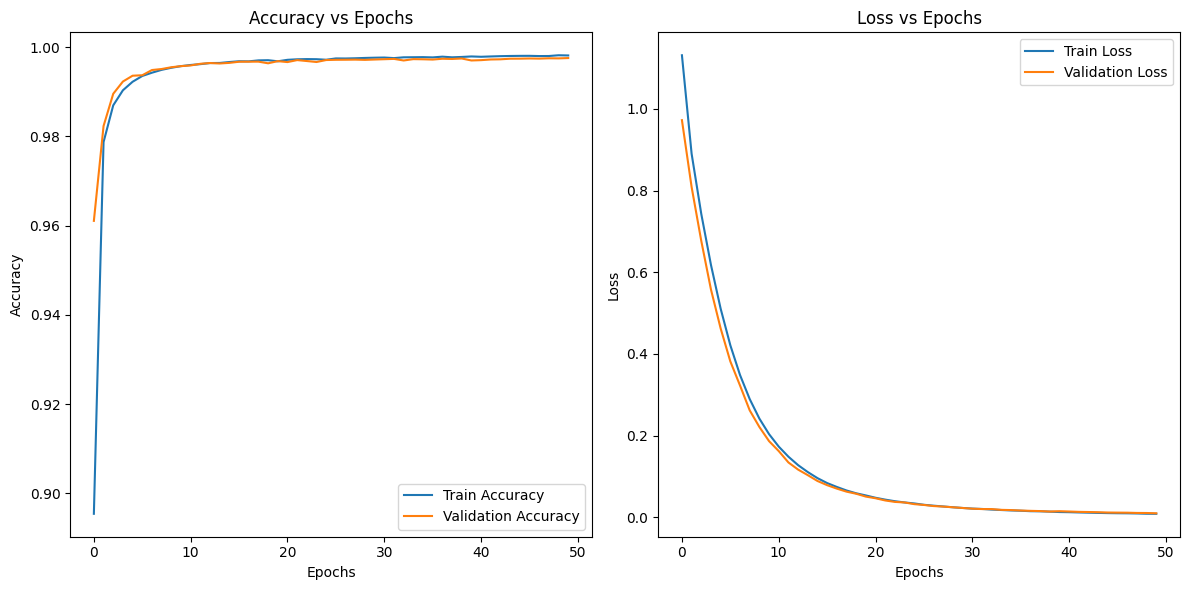


Final Metrics for Each Class:
Class      Precision    Recall     F1-Score  
Liver      0.998897     0.998488   0.998692  
Kidney     0.986330     0.990620   0.988471  
Spleen     0.975454     0.982471   0.978950  
Pancreas   0.972135     0.990156   0.981063  
Other      0.935227     0.896970   0.915699  


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as T
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
from sklearn.metrics import classification_report

# Helper function to compute metrics for evaluation
def compute_metrics(model, data_loader):
    """Compute precision, recall, and F1-score for multi-class segmentation."""
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            preds = outputs.argmax(1).cpu().numpy()  # Predicted class indices
            labels = labels.cpu().numpy()  # Ground truth class indices
            
            all_preds.append(preds.ravel())
            all_labels.append(labels.ravel())

    # Flatten the arrays
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Compute metrics
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    return precision, recall, f1

# Paths to the dataset
train_imgs_path = '/kaggle/input/dataset/dataset/train_imgs'
train_labels_path = '/kaggle/input/dataset/dataset/train_lbs'

# Define the transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.225])
])

# Load dataset
full_dataset = CTImageDataset(train_imgs_path, train_labels_path, transform=transform)

# Split dataset into training and validation
val_size = 100
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Initialize the model, loss function, and optimizer
model = OrganSegNet(num_classes=5).cuda()  # for GPU usage
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Helper function to compute accuracy
def compute_accuracy(output, target):
    _, preds = torch.max(output, 1)  # Get predicted class
    correct = (preds == target).sum().item()
    total = target.numel()  # Total number of pixels
    return correct / total

# Training and validation loop
num_epochs = 50
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    train_correct = 0
    train_total = 0
    epoch_train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

        # Accuracy calculation
        train_correct += (outputs.argmax(1) == labels).sum().item()
        train_total += labels.numel()

    train_losses.append(epoch_train_loss / len(train_loader))
    train_accuracy_epoch = train_correct / train_total
    train_accuracies.append(train_accuracy_epoch)

    # Validation Phase
    model.eval()
    val_correct = 0
    val_total = 0
    epoch_val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)

            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()

            # Accuracy calculation
            val_correct += (outputs.argmax(1) == labels).sum().item()
            val_total += labels.numel()

    val_losses.append(epoch_val_loss / len(val_loader))
    val_accuracy_epoch = val_correct / val_total
    val_accuracies.append(val_accuracy_epoch)

    # Print epoch summary
    print(f'Epoch [{epoch + 1}/{num_epochs}] - '
          f'Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, '
          f'Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}')

# Plot training/validation accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Helper function to compute detailed metrics for each class
def compute_detailed_metrics(model, data_loader, class_names):
    """Compute precision, recall, and F1-score for each class."""
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            preds = outputs.argmax(1).cpu().numpy()  # Predicted class indices
            labels = labels.cpu().numpy()  # Ground truth class indices
            
            all_preds.append(preds.ravel())
            all_labels.append(labels.ravel())

    # Flatten the arrays
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0, output_dict=True)
    
    # Print table-like output
    print("\nFinal Metrics for Each Class:")
    print("{:<10} {:<12} {:<10} {:<10}".format("Class", "Precision", "Recall", "F1-Score"))
    for i, class_name in enumerate(class_names):
        print("{:<10} {:<12.6f} {:<10.6f} {:<10.6f}".format(
            class_name, 
            report[class_name]['precision'], 
            report[class_name]['recall'], 
            report[class_name]['f1-score']
        ))

    return report

# Define class names for your dataset
class_names = ['Liver', 'Kidney', 'Spleen', 'Pancreas', 'Other']

# Compute detailed metrics after training
detailed_metrics = compute_detailed_metrics(model, val_loader, class_names)

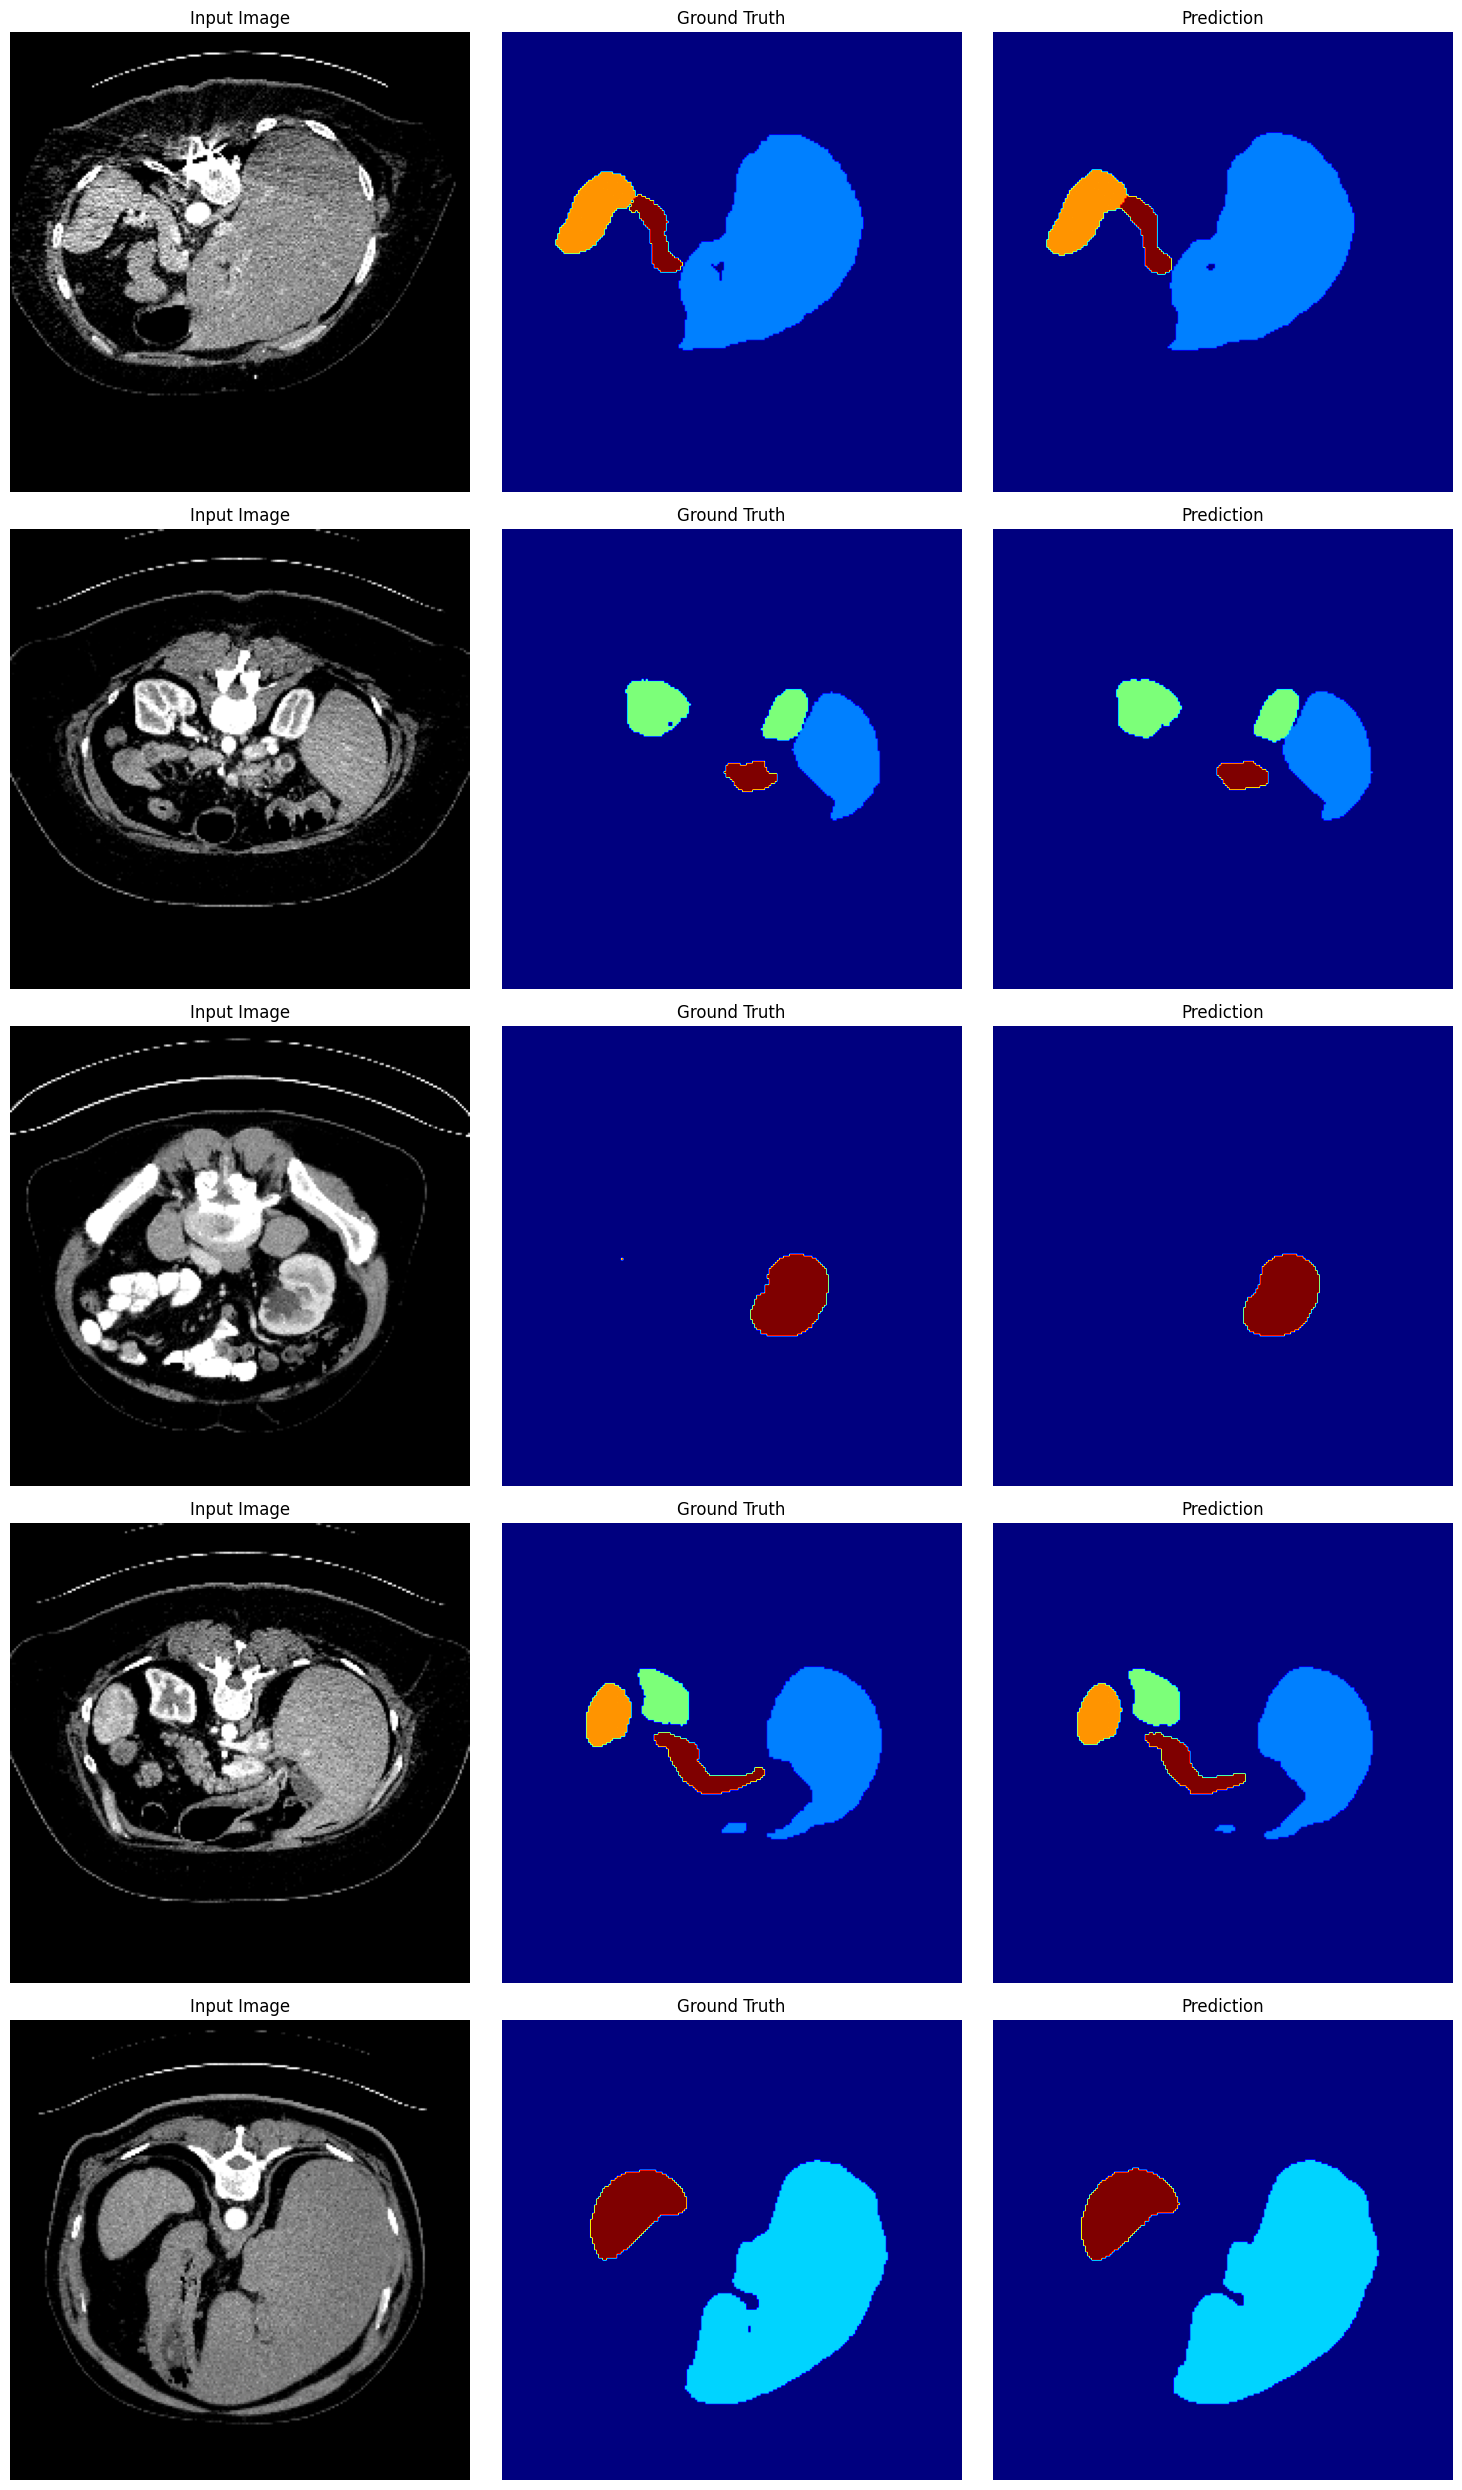

In [8]:
def visualize_predictions(model, dataset, num_samples=10):
    model.eval()
    samples = np.random.choice(len(dataset), num_samples, replace=False)

    plt.figure(figsize=(15, 5 * num_samples))
    for i, idx in enumerate(samples):
        image, label = dataset[idx]
        image = image.unsqueeze(0).cuda()  # Add batch dimension
        with torch.no_grad():
            output = model(image)
            prediction = output.argmax(1).squeeze().cpu().numpy()

        # Plot
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(image.cpu().squeeze(), cmap='gray')
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(label.cpu().numpy(), cmap='jet')
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(prediction, cmap='jet')
        plt.title('Prediction')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_predictions(model, val_dataset, num_samples=5)


In [ ]:
import numpy as np
import cv2
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import os
from tqdm import tqdm  
from PIL import Image

class TestDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image_name = os.path.basename(image_path).split(".")[0]

        # Load the grayscale image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as single-channel

        if self.transform:
            # Apply transformations (e.g., ToTensor, Normalize)
            image = self.transform(image)

        # Return the image name and the preprocessed image
        return image_name, image



# Define Run-Length Encoding (RLE) function
def rle_encoding(mask):
    """
    Perform Run-Length Encoding for a given binary mask.
    Args:
        mask: Binary mask (2D numpy array)
    Returns:
        rle: Encoded RLE string
    """
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(map(str, runs))


# Define transformations specifically for grayscale images
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to tensor with shape [1, H, W] for grayscale
    transforms.Normalize(mean=[0.485], std=[0.225])  # Normalize single channel
])

# Assuming test images are stored in 'test_imgs_path'
test_imgs_path = '/kaggle/input/dataset/dataset/test_imgs'


# Create DataLoader for test set
test_dataset = TestDataset(test_imgs_path, transform=transform)  # No labels for test set
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Prepare the submission DataFrame
submission = []

# Set the model to evaluation mode
model.eval()

# Loop over test set images
for image_name, image in tqdm(test_loader, desc="Predicting Masks"):
    image_name = image_name[0]  # Extract image name
    image = image.cuda()

    # Get model prediction
    with torch.no_grad():
        output = model(image)  # Model output
        preds = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # Convert to numpy array

    # Generate RLE for each class
    for class_idx in range(5):
        mask = (preds == class_idx).astype(np.uint8)  # Binary mask for the class
        rle = rle_encoding(mask)
        submission.append({
            "Id": f"{image_name}_{class_idx}",
            "Predicted": rle
        })

    

# Create the final submission DataFrame
submission_df = pd.DataFrame(submission)

# Save the submission to CSV
submission_df.to_csv('/kaggle/working/submissionhaha.csv', index=False)

print("Submission file created successfully!")


Predicting Masks: 100%|██████████| 143/143 [00:01<00:00, 141.38it/s]

Submission file created successfully!
